# 沪深300数据集的算法实现 (Daily)
对我所实现的模型的缺陷的设想：
1. 未剔除剔除黑名单股票和不可交易股票，其中黑名单包括新股（上市不满12个月）、风险警示股、待退市股和净资产为负股，不可交易股票包括停牌股票和一字板股票。
2. 未考虑26年间持仓股票（可能）遭遇退市的情况。
3. 作为每日换仓的算法，应当考虑至少万分之五的佣金和手续费。
4. 日频换仓应更偏向于短期的趋势线交易，在模型中加入包含Market Value和Book-to-Market ratio的基本面因子是否有效？同时没有考虑到短期的不正常波动（应当设置止损和止盈点？或者根据股价所在的历史价格百分位设置惩罚因子？）
5. 动量积累的路径很重要！在同一时间段内看似相同（实则由不同路径积累）的动量可能在该时间段内保持上涨的天数相差巨大（例如来源于短期的高波动）。

In [1]:
import akshare as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re

# 1. 从本地读取数据

In [2]:
# 从本地读取HS300所有成分股自1995年1月1日至2021年12月31日间所有交易日的收盘价、日回报率、账面市值比与市值。
close_df = pd.read_csv("C:\\Users\\asus\\Desktop\\Carhart\\HS300_data\\close.csv", 
                       index_col = "trade_date")
return_df = pd.read_csv("C:\\Users\\asus\\Desktop\\Carhart\\HS300_data\\return.csv", 
                        index_col = "trade_date")
BM_df = pd.read_csv("C:\\Users\\asus\\Desktop\\Carhart\\HS300_data\\BM.csv", 
                    index_col = "trade_date")
MV_df = pd.read_csv("C:\\Users\\asus\\Desktop\\Carhart\\HS300_data\\MV.csv", 
                    index_col = "trade_date")

# 将利率转换为小数
return_df = return_df / 100

In [3]:
# 将日期转换为datetime
close_df.index = pd.to_datetime(close_df.index)
return_df.index = pd.to_datetime(return_df.index)
BM_df.index = pd.to_datetime(BM_df.index)
MV_df.index = pd.to_datetime(MV_df.index)

In [4]:
# 从本地读取用以计算无风险收益率的相关指标数据，并
# 三个月期定期银行存款利率
deposit_interest_rate = pd.read_csv(
    "C:\\Users\\asus\\Desktop\\Carhart\\HS300_data\\deposit_interest_rate.csv", 
    encoding = "gbk").fillna(method = "ffill")[["pubDate", "fixedDepositRate3Month"]]

# 三个月期中央银行票据的票面利率
central_bank_bill = pd.read_csv(
    "C:\\Users\\asus\\Desktop\\Carhart\\HS300_data\\central_bank_bill.csv", 
    encoding = "gbk").fillna(method = "ffill")[["short_name", "list_date"]]

# 上海银行间三个月同业拆放利率
shibor = pd.read_csv(
    "C:\\Users\\asus\\Desktop\\Carhart\\HS300_data\\shibor.csv", 
    encoding = "gbk").fillna(method = "ffill")

# 2. 进行利率转换(以91记3个月，复利计息)以及相关数据的操作

| 时间(t) | 数据来源 |
| :--- | ----: |
| t $\leq$ 2002-08-06 | 三个月期定期银行存款利率 |
| 2002-08-07 $\leq$ t $\leq$ 2006-10-07 | 三个月期中央银行票据的票面利率 |
| 2006-10-08 $\leq$ t | 上海银行间三个月同业拆放利率 |


In [5]:
deposit_interest_rate = deposit_interest_rate.rename(columns = {"fixedDepositRate3Month": "rate",
                                                                "pubDate": "date"})
deposit_interest_rate["date"] = pd.to_datetime(deposit_interest_rate["date"])

# 利率转为小数再转为等价单日利息
deposit_interest_rate["rate"] = (1 + deposit_interest_rate["rate"] / 100)**(1/91) - 1

In [6]:
central_bank_bill["list_date"] = pd.to_datetime(central_bank_bill["list_date"])
central_bank_bill["rate"] = None
central_bank_bill.rename(columns={"list_date": "date"}, inplace = True)
billLst = [['2003.04.30',2.1800],['2003.05.07',2.1500],['2003.05.14',2.1900],['2003.05.21',2.1500],
           ['2003.05.28',2.1900],['2003.06.04',2.1900],['2003.06.11',2.2300],['2003.06.18',2.2700],
           ['2003.06.25',2.3100],['2003.07.02',2.3100],['2003.07.09',2.3100],['2003.07.16',2.3100],
           ['2003.07.23',2.3100],['2003.07.30',2.3100],['2003.08.06',2.3100],['2003.08.13',2.2700],
           ['2003.08.20',2.3500],['2003.08.27',2.4300],['2003.09.03',2.6600],['2003.09.10',2.7100],
           ['2003.09.17',2.7100],['2003.09.24',2.6600],['2003.10.15',2.7200],['2003.10.22',2.6800],
           ['2003.10.29',2.7200],['2003.11.12',2.8000],['2003.11.19',2.7200],['2003.11.26',2.4400],
           ['2003.12.03',2.4600],['2003.12.10',2.4600],['2003.12.17',2.4600],['2003.12.24',2.4600],
           ['2003.12.31',2.4600],['2004.01.07',2.4600],['2004.01.14',2.4600],['2004.01.21',2.4600],
           ['2004.02.04',2.4600],['2004.02.11',2.3500],['2004.02.18',2.2700],['2004.02.25',2.0600],
           ['2004.03.03',1.9900],['2004.03.10',1.9100],['2004.03.17',1.8700],['2004.03.24',2.1900],
           ['2004.03.31',2.1100],['2004.04.07',2.1400],['2004.04.14',2.1400],['2004.05.19',2.8000],
           ['2004.05.26',2.7200],['2004.06.02',2.8000],['2004.06.23',2.8000],['2004.06.30',2.8800],
           ['2004.07.07',2.8400],['2004.07.14',2.8400],['2004.07.21',2.8800],['2004.08.06',2.8600],
           ['2004.08.13',2.8200],['2004.08.20',2.7400],['2004.08.27',2.6200],['2004.09.03',2.4200],
           ['2004.09.10',2.3000],['2004.09.17',2.4200],['2004.09.24',2.5000],['2004.09.29',2.4200],
           ['2004.10.15',2.4600],['2004.10.22',2.5400],['2004.10.29',2.5800],['2004.11.05',2.5800],
           ['2004.11.12',2.5300],['2004.11.19',2.5000],['2004.11.26',2.5000],['2004.12.03',2.4600],
           ['2004.12.10',2.1400],['2004.12.17',2.4600],['2004.12.24',2.6600],['2004.12.31',2.6600],
           ['2005.01.07',2.5800],['2005.01.14',2.5400],['2005.01.21',2.3800],['2005.02.18',2.3800],
           ['2005.02.25',2.2600],['2005.03.04',2.1800],['2005.03.11',2.0200],['2005.03.17',2.3800],
           ['2005.03.18',1.4500],['2005.03.25',1.2900],['2005.04.01',1.2100],['2005.04.08',1.1700],
           ['2005.04.15',1.0900],['2005.04.22',1.1700],['2005.04.29',1.0900],['2005.05.13',1.2100],
           ['2005.05.20',1.2100],['2005.05.27',1.2100],['2005.06.03',1.1700],['2005.06.10',1.0900],
           ['2005.06.17',1.0900],['2005.06.24',1.1700],['2005.07.01',1.2100],['2005.07.08',1.1500],
           ['2005.07.15',1.1300],['2005.07.22',1.1300],['2005.07.29',1.0900],['2005.08.05',1.0900],
           ['2005.08.12',1.0900],['2005.08.19',1.0500],['2005.08.26',1.0900],['2005.09.02',1.0900],
           ['2005.09.09',1.0900],['2005.09.16',1.1300],['2005.09.23',1.1700],['2005.09.30',1.1700],
           ['2005.10.14',1.1700],['2005.10.21',1.1700],['2005.10.28',1.1700],['2005.11.04',1.2200],
           ['2005.11.11',1.3700],['2005.11.18',1.4900],['2005.11.25',1.6100],['2005.12.02',1.8100],
           ['2006.02.10',1.7300],['2006.02.17',1.7300],['2006.02.24',1.7700],['2006.03.03',1.7300],
           ['2006.03.10',1.7300],['2006.03.24',1.7700],['2006.03.31',1.8100],['2006.04.07',1.8100],
           ['2006.04.14',1.8500],['2006.04.21',1.8900],['2006.04.28',1.9800],['2006.05.12',2.0200],
           ['2006.05.19',2.0200],['2006.05.26',2.0600],['2006.06.02',2.1000],['2006.06.09',2.1400],
           ['2006.06.16',2.1800],['2006.06.23',2.2600],['2006.06.30',2.3400],['2006.07.07',2.3700],
           ['2006.07.14',2.3800],['2006.07.21',2.3800],['2006.07.28',2.3800],['2006.08.04',2.4200],
           ['2006.08.11',2.4200],['2006.08.18',2.5000],['2006.08.25',2.5400],['2006.09.01',2.5400],
           ['2006.09.08',2.5000],['2006.09.15',2.4600],['2006.09.22',2.4600],['2006.09.29',2.4600],
           ['2006.10.13',2.5000]]

billLst = list(zip(*zip(list(map(lambda x: x[0],billLst)), list(map(lambda x: x[1],billLst)))))
billLst = pd.DataFrame(billLst[0], index = billLst[1]).reset_index()
billLst = billLst.rename(columns={"index": "rate", 0: "date"})
billLst["date"] = pd.to_datetime(billLst["date"])
central_bank_bill = pd.merge(central_bank_bill, billLst, how = "inner", on="date")
del central_bank_bill["rate_x"], central_bank_bill["short_name"]
central_bank_bill = central_bank_bill.rename(columns = {"rate_y": "rate"})
central_bank_bill.iloc[0, 0] = pd.to_datetime("2002-08-07")

# 利率转为小数再转为等价单日利息
central_bank_bill["rate"] = (1 + central_bank_bill["rate"] / 100)**(1/91) - 1


In [7]:
central_bank_bill

,date,rate
0,2002-08-07,0.000310
1,2004-08-13,0.000306
2,2004-08-20,0.000297
3,2004-08-27,0.000284
4,2004-09-03,0.000263
...,...,...
93,2006-09-08,0.000271
94,2006-09-15,0.000267
95,2006-09-22,0.000267
96,2006-09-29,0.000267


In [8]:
shibor = shibor[["date", "shibor3M"]].rename(columns = {"shibor3M": "rate"})
shibor["date"] = pd.to_datetime(shibor["date"].values)
shibor.iloc[-1, 0] = pd.to_datetime("2021-12-31")

# 利率转为小数再转为等价单日利息
shibor["rate"] = (1 + shibor["rate"] / 100)**(1/91) - 1

# 3. 参数设置 

In [9]:
# 初始时间设置
startDate, endDate = "19950101", "20211231"  # 时间区间

# 检查时间区间是否有效
if int(startDate) > int(endDate) or int(endDate) > datetime.date.today().year * 10000 + \
        datetime.date.today().month * 100 + dat......etime.date.today().day:
    print("Invalid Time Interval")
    quit()

In [10]:
# 其它初始模型参数设置
tradePercent = 0.1  # 多空比例

# 仅在月频交易中使用
laggedPeriod = pd.Timedelta("30 D")  # 从今天倒推不计入windowPeriod的时间
windowPeriod = pd.Timedelta(str(30 * 11) + " D")  # 回溯期，以计算累计收益率
holdPeriod = pd.Timedelta("30 D")  # 持有新投资组合的时间

In [11]:
# 获取交易日历
def GetTradeCalender(start: str, end: str) -> pd.Series:
    cal = ak.tool_trade_date_hist_sina()
    return cal["trade_date"][
        (datetime.date(int(start[:4]),int(start[4:6]), int(start[6:])) <= cal["trade_date"]) & 
        (cal["trade_date"] <= datetime.date(int(end[:4]), int(end[4:6]), int(end[6:])))]

calender = pd.to_datetime(GetTradeCalender(startDate, endDate))

## 对于沪深300选取初始时间

In [12]:
def CountValidData(row):
    return len(row) - sum(pd.isnull(row))

# 计算沪深300每日有效数据，选取开始日期应满足达到一定有效数据量
dailyValidData = pd.Series(list(map(min, close_df.apply(CountValidData, axis = 1), 
                                    return_df.apply(CountValidData, axis = 1), 
                                    BM_df.apply(CountValidData, axis = 1), 
                                    MV_df.apply(CountValidData, axis = 1))), 
                           index = calender.values, name = "trade_date")

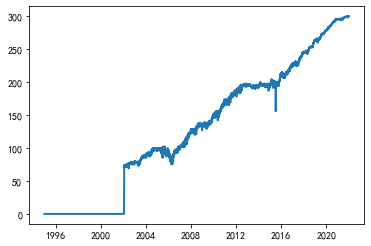

In [13]:
print(plt.plot(dailyValidData.index, dailyValidData.values, ls="-", lw=2, label = "Valid Data Available"))

According to the plot, we may change our start date from 2004-01-01, since when the data were becoming sufficient for conducting analysis, however, this step can be skipped if we use all stocks in the population space. 

In [14]:
# 缩小数据集至可行范围（自2004年1月1日）
close_df = close_df[close_df.index >= pd.to_datetime("2004-01-01")]
return_df = return_df[return_df.index >= pd.to_datetime("2004-01-01")]
BM_df = BM_df[BM_df.index >= pd.to_datetime("2004-01-01")]
MV_df = MV_df[MV_df.index >= pd.to_datetime("2004-01-01")]
calender = calender[calender.values >= pd.to_datetime("2004-01-01")]

# 4. 计算各因子
According to $\mathbf{\mathit{\mbox{On Persistence in Mutual Fund Performanc}}}$ by $\mathbf{\mbox{MarK M. Carhart}}$ himself, the model can be interpreted as the following formula:

$$
\mathbb{E}[r_{p,t}] - r_{f} = \alpha + \beta_{RMRF_{p,t}}RMRF_{p,t} + \beta_{SMB_{p,t}}SMB_{p,t} + \beta_{HML_{p,t}}HML_{p,t} + \beta_{UMD_{p,t}}UMD_{p,t}
$$

Where $r_{f}$ is the risk-free interest rate, RMRF is the market risk premium = $r_{M}-r_{f}$, and $\mathbb{E}[r_{p, t}]$ is the expected return of portfolio under our assumptions.

## 4.1. 根据算法建立表示动量的DataFrame，在日频交易中，以过去 12 天（剔除昨天）的11天计算累计收益率。

In [15]:
# 建立动量变量DataFrame
momentum = return_df.copy()

for days in range(2, 13):
    momentum = return_df.copy().shift(days, axis = 0)

In [16]:
# 根据日期得到该日各支股票的总市值权重
def GetWeightArray(date: pd.datetime) -> np.array:
    row = MV_df[MV_df.index == date].iloc[0].values
    return row / np.nansum(row)


# 根据日期得到该日的市场回报率
def GetMarketReturn(date: pd.datetime) -> float:
    weight = GetWeightArray(date)
    row = return_df[return_df.index == date].iloc[0].values
    return np.nansum([weight[i]*row[i] for i in range(len(row))])


# 定义函数，根据日期确定当日无风险收益率
def RF(date: pd.datetime) -> float:
    if date <= pd.to_datetime("2002-08-06"):
        df = deposit_interest_rate
        
    elif date <= pd.to_datetime("2006-10-07"):
        df = central_bank_bill
    else:
        df = shibor
    
    if df[date <= df.iloc[:, 0].values].shape[0] != 0:
        return df[date <= df.iloc[:, 0].values].iloc[0, 1]
    else:
        raise Exception("Time Interval Exceeded!")


# 根据日期得到该日SMB因子
def GetSMB(date: pd.datetime) -> float:
    row = list(MV_df[MV_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    # 此处与之前不同在于，可能出现某股票某日市值不缺失但收益率缺失的情况（例如该股票停牌），
    # 因此必须过滤掉这些公司，否则会影响筛选公司市值，因为当日不能交易则无法Long或者Short。
    # 但以上函数不必过滤，尽管权重之和有可能不等于1，但并不会对算法产生本质影响。
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    # 根据多空比例（分位数）确定long与short的标的。
    [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
    row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
    return  np.dot(weight[row <= lower_bound], returnRow[row <= lower_bound]) - np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound])
    
    
# 根据日期得到该日HML因子
def GetHML(date: pd.datetime) -> float:
    row = list(BM_df[BM_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    # 同理，需要过滤当日无法交易的股票
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    # 根据多空比例（分位数）确定long与short的标的。
    [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
    row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
    return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[row <= lower_bound], returnRow[row <= lower_bound])


# 根据日期得到该日UMD因子
def GetUMD(date: pd.datetime) -> float:
    row = list(momentum[momentum.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    # 同理，需要过滤当日无法交易的股票
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        # 根据多空比例（分位数）确定long与short的标的。
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[row <= lower_bound], returnRow[row <= lower_bound])

## 4.2.  创建最终输出的因子DataFrame，并运算结果

In [17]:
fourFactor = pd.DataFrame({"RF": np.nan, "MKT": np.nan, "RMRF": np.nan , "SMB": np.nan, 
                           "HML": np.nan, "UMD": np.nan}, index = pd.to_datetime(calender.values))

fourFactor["RF"] = np.array(map(RF, fourFactor.index))
fourFactor["MKT"] = np.array(map(GetMarketReturn, fourFactor.index))
fourFactor["RMRF"] = fourFactor["MKT"] - fourFactor["RF"]
fourFactor["SMB"] = np.array(map(GetSMB, fourFactor.index))
fourFactor["HML"] = np.array(map(GetHML, fourFactor.index))
fourFactor["UMD"] = np.array(map(GetUMD, fourFactor.index))

fourFactor.to_csv("C:\\Users\\asus\\Desktop\\Carhart\\HS300_data\\Factor_Result.csv", 
                  index = True, header = True)

In [18]:
len(calender)

4375